### First experiments with U-Net on FOCI slp data

Trained model with **variable mask** and **augmentation factor 3** on samples with rel. amount of missing values in the **range of [0,1]**.

Use this single model to find the **optimized sampling strategy** in a brute-force manner.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [7]:
## Reload parameters and results for experiment:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'FOCI' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'variable'
missing_type = 'range_0_100'
augmentation_factor = 3
run = '_final'
exp_name = '/relevance_2'

# Get path to stored results:
path_to_stored_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_stored_results)

# Reload parameters relevant for data pre-processing for this experiment:
with open(path_to_stored_results / 'parameters.json', 'r') as f:
    parameters=load(f)


train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']
n_samples = parameters['n_samples']
patch_size = parameters['patch_size']
max_patch_num = parameters['max_patch_num']
max_acc_rel_loss_reduction = parameters['max_acc_rel_loss_reduction']

# Print parameters:
print("\nnumber of samples: ", n_samples)
print("patch size: ", patch_size)
print("max. number of patches to include: ", max_patch_num)
print("max. acc. rel. loss as threshold: ", max_acc_rel_loss_reduction)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_0_100_factor_3_final/relevance_2

number of samples:  600
patch size:  1
max. number of patches to include:  50
max. acc. rel. loss as threshold:  0.9


In [15]:
# ## For the following individual list of samples:

# relevance_3_samples = [
#     0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,
#     40,41,42,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,9530,9531,9532,9533,9534,9535,9536,9537,9538,9539,
#     9540,9541,9542,9543,9544,9545,9546,9548,9549,9550,9551,9553,9554,9555,9556,9557,9558,9559,9560,9561,9562,
#     9563,9564,9565,9566,9567,9568,9569,9570,9571,9572,9573,9574,9575,9576,9577,9578,9579,9580,9581,9582,9583,
#     9584,9585,9586,9587,9588,9589
# ]

# # Combine results:
# for n in relevance_3_samples:

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in relevance_3_samples:  

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:   

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (113, 96, 144)
patch_orders: (113, 13824)
rel_loss_reductions: (113, 13824)
abs_loss_reductions: (113, 13824)
acc_rel_loss_reductions: (113, 13824)


In [4]:
# ## For complete list of samples:

# start_at = 0
# end_at = start_at + n_samples

# # Combine results:
# for n in np.arange(start_at,end_at): 

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):   

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (120, 96, 144)
patch_orders: (120, 13824)
rel_loss_reductions: (120, 13824)
abs_loss_reductions: (120, 13824)
acc_rel_loss_reductions: (120, 13824)


In [5]:
# start_at = 9300
# end_at = 9300+180

# # Reload results for this experiment:
# rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
# patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
# abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
# rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions_.npy")
# acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders_new.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (600, 96, 192)
patch_orders: (600, 18432)
rel_loss_reductions: (600, 18432)
abs_loss_reductions: (600, 18432)
acc_rel_loss_reductions: (600, 18432)


In [6]:
# # Get path to model:
# path_to_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
#                       +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

# # Reload final model, trained on range:
# model = tf.keras.models.load_model(path_to_model / 'missing_0_100' / 'model')

2023-03-08 05:08:16.456441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-03-08 05:08:16.456463: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 05:08:16.456476: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl211): /proc/driver/nvidia/version does not exist
2023-03-08 05:08:16.461472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
## Prepare validation samples:

# Path to full data:
# path_to_data = 'climate_index_collection/data/raw/2022-08-22/'
path_to_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# Load data:
data_raw = load_data_set(data_path=path_to_data, data_source_name=source)

# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature=feature, data_set=data_raw)

# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(data.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
train_input, val_input, _, _, train_min, train_max, _, _ = split_and_scale_data(
    data, 
    missing_mask_1,
    train_val_split, 
    scale_to
)

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [9]:
# Get possible number of patches in lat and lon directions, respectively:
n_lat = int(val_input[0:1].shape[1] / patch_size)
n_lon = int(val_input[0:1].shape[2] / patch_size)

# Obtain total number of patches:
n_patches = int(n_lat * n_lon)

# If max. number of patches to include is given as -1, set to total number of possible patches:
if max_patch_num == -1:
    max_patch_num = n_patches

In [11]:
# Reload results for this experiment:
rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# Check dimensions:
print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
print("patch_orders:", patch_orders.shape)
print("rel_loss_reductions:", rel_loss_reductions.shape)
print("abs_loss_reductions:", abs_loss_reductions.shape)
print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (600, 96, 192)
patch_orders: (600, 18432)
rel_loss_reductions: (600, 18432)
abs_loss_reductions: (600, 18432)
acc_rel_loss_reductions: (600, 18432)


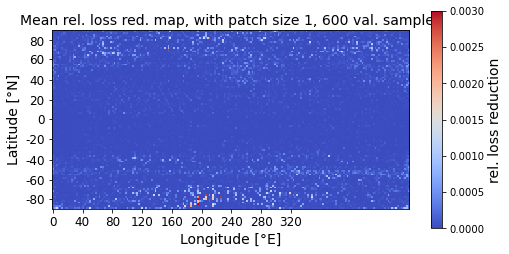

In [12]:
## range_0_100, relevance_2: TRAINING samples!
# Include 600 samples, 300 from both edges of the time line.
# patch_size = 1
# max_patch_num = 50
# max_acc_rel_loss_reduction = 0.9

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

/tmp/ipykernel_1937063/3221499229.py:2: RuntimeWarning: Mean of empty slice
  mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)


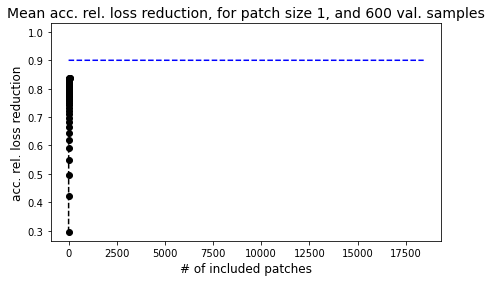

In [13]:
# Compute mean acc. rel. loss reduction, over desired number of considered validation samples:
mean_acc_rel_loss_reduction = np.nanmean(acc_rel_loss_reductions[:n_samples],axis=0)

# Plot mean acc. rel. loss reduction over desired number of patches to include:
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,n_patches,step=1)+1, mean_acc_rel_loss_reduction[:n_patches], color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,n_patches,step=1)+1, np.ones(n_patches)*0.9, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('Mean acc. rel. loss reduction, for patch size '+str(patch_size)+', and '+str(n_samples)+' val. samples', fontsize=14)
axes.set_xlabel('# of included patches', fontsize=12)
axes.set_ylabel('acc. rel. loss reduction', fontsize=12)
#axes.legend()
plt.show() 